# RunTS

`mth5.timeseries.RunTS` is a container to hold multiple synchronous channels of the same sampling rate.  The data is contained in an `xarray.DataSet` which is a collection of `ChannelTS.to_xarray()` objects.  

In [1]:
%matplotlib inline
import numpy as np
from mth5.timeseries import ChannelTS, RunTS
from mt_metadata.timeseries import Electric, Magnetic, Auxiliary, Run, Station

2023-03-26 16:04:38,874 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


## Create a Run 

We will create a common run that has all 5 channels of an MT measurement (Hx, Hy, Hz, Ex, Ey) plus an auxiliary channel.  We will make individual channels first and then add them into a `RunTS` object. 

In [2]:
channel_list = []
common_start = "2020-01-01T00:00:00"
sample_rate = 8.0
n_samples = 4096
t = np.arange(n_samples)
data = np.sum([np.cos(2*np.pi*w*t + phi) for w, phi in zip(np.logspace(-3, 3, 20), np.random.rand(20))], axis=0)

station_metadata = Station(id="mt001")
run_metadata = Run(id="001")

### Create `magnetic` channels

In [3]:
for component in ["hx", "hy", "hz"]:
    h_metadata = Magnetic(component=component)
    h_metadata.time_period.start = common_start
    h_metadata.sample_rate = sample_rate
    h_channel = ChannelTS(
        channel_type="magnetic",
        data=data,
        channel_metadata=h_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(h_channel)
    

### Create `electric` channels

In [4]:
for component in ["ex", "ey"]:
    e_metadata = Electric(component=component)
    e_metadata.time_period.start = common_start
    e_metadata.sample_rate = sample_rate
    e_channel = ChannelTS(
        channel_type="electric",
        data=data,
        channel_metadata=e_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
    channel_list.append(e_channel)

### Create `auxiliary` channel

In [6]:
aux_metadata = Auxiliary(component="temperature")
aux_metadata.time_period.start = common_start
aux_metadata.sample_rate = sample_rate
aux_channel = ChannelTS(
        channel_type="auxiliary",
        data=np.random.rand(n_samples) * 30,
        channel_metadata=aux_metadata,
        run_metadata=run_metadata,
        station_metadata=station_metadata)
aux_channel.channel_metadata.type = "temperature"
channel_list.append(aux_channel)

## Create `RunTS` object

Now that we have made individual channels we can make a `RunTS` object by inputing a list of `ChannelTS` objects. 

**Note**: This can also be a list of `xarray.DataArray` objects formated like a channel.

In [7]:
run = RunTS(channel_list)

In [8]:
run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:08:31.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

## Plot Run
Again this is a hack at the moment, we are working on a better visualization, but this works for now.

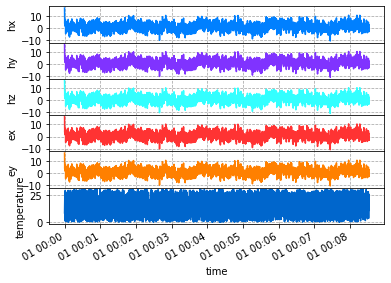

In [9]:
run.plot()

## Merge Runs

It can be benificial to add runs together to create a longer time series.  To combine runs each run must have the same sample rate.  There are 2 builtin options for combining runs 
  
  1. `added_run = run_01 + run_02`
  2. `merged_run = run_01.merge(run_02)` 
  
Both methods use `xarray.combine_by_coords([run1, run2], combine_attrs='override'`.  The `combine_by_coords` method simply concatenates along similar dimensions and cares nothing of a monotonix dimension variable.  Therefore, `xarray.DataSet.reindex` is used to create a monotonically increasing time series.  Any gabs are filled interpolated using a 1-D interpolation.  The default method is `slinear` which is probably the most useful for processing time series.  If you want more control over the interpolation method use `RunTS.merge([run1, run2, ...], gap_method=interpolation_method`.  For more information on interpolation methods see [Scipy.interpolate.interp1d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html). Similarly if you want more control on how the datasets are merged use [xarray tools](https://docs.xarray.dev/en/stable/user-guide/combining.html).  

### Using `+`

Using `run_01 + run_02` will combine and interpolate onto a new monotonic time index.  Any gaps will be interpolated linearly interpolated.  If channels are different Nan's will be placed where channels do not overlap.  If you have `hz` in `run_01` but not `run_02` then Nan's will be place in `hz` for the time period of `run_02`.  

In [10]:
for ch in channel_list:
    ch.start = "2020-01-01T00:08:45"
run_02 = RunTS(channel_list)

2023-03-26 16:05:49,823 [line 521] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-01-01T00:17:16.875000+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:16.875000+00:00


In [11]:
added_run = run + run_02

2023-03-26 16:05:50,261 [line 521] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-01-01T00:17:16.875000+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:16.875000+00:00


In [12]:
added_run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:17:16.875000+00:00
	Sample Rate: 8.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

#### Plot combined run

Plotting you can see the linear interpolation in the gap of time between the runs.  Here it makes a spike because the first point in the time series is a spike.

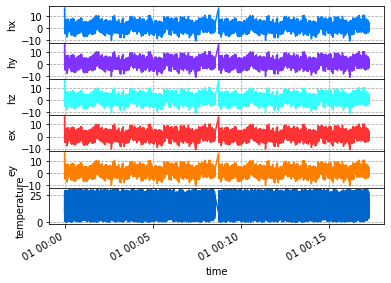

In [13]:
added_run.plot()

### Using Merge and Decimating

Using `merge` is a little more flexible and many runs can be merged together at the same time.  Note if you use `run_01 + run_02 + run_03` it only combines 2 at a time, which can be inefficient if multiple runs are combined.  `RunTS.merge` provides the option of combining multiple runs and also decimating to lower sample rate with the keyword `new_sample_rate`.

#### Runs with different sample rates

When using merge not all runs need to have the same sample rate, but you need to set `new_sample_rate` to the common sample rate for the combined runs.  This will resample the each run to the `new_sample_rate` before combining.  Resampling is done with (xarray.Dataset.resample)[https://docs.xarray.dev/en/stable/generated/xarray.Dataset.resample.html].   

#### Change interpolation method

To change how gaps are interpolated change the `gap_method` parameter.  See (scipy.interpolate.interp1d)[https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html]

Options are 

  - ‘linear’
  - ‘nearest’
  - ‘nearest-up’
  - ‘zero’
  - ‘slinear’ (*default*)
  - ‘quadratic’
  - ‘cubic’
  - ‘previous’
  - ‘next’

In [14]:
merged_run = run.merge(run_02, new_sample_rate=1, gap_method="slinear")

2023-03-26 16:05:51,531 [line 521] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-01-01T00:17:16+00:00 does not match metadata end 2020-01-01T00:17:16.875000+00:00 updating metatdata value to 2020-01-01T00:17:16+00:00
2023-03-26 16:05:51,989 [line 521] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2020-01-01T00:17:16+00:00 does not match metadata end 2020-01-01T00:08:31.875000+00:00 updating metatdata value to 2020-01-01T00:17:16+00:00
2023-03-26 16:05:51,992 [line 532] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: sample rate of dataset 1.0 does not match metadata sample rate 8.0 updating metatdata value to 1.0


In [15]:
merged_run

RunTS Summary:
	Survey:      0
	Station:     mt001
	Run:         001
	Start:       2020-01-01T00:00:00+00:00
	End:         2020-01-01T00:17:16+00:00
	Sample Rate: 1.0
	Components:  ['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

#### Plot

Plot the merged runs downsampled to 1 second, and the linear interpolation is more obvious. 

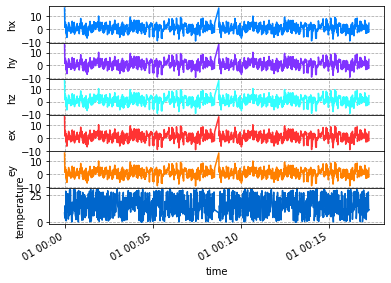

In [16]:
merged_run.plot()

## To/From Obspy.Stream

When data is downloaded from an FDSN client or data is collected as miniseed Obspy is used to contain the data as a `Stream` object.  Transformation between `RunTS` and `Stream` is supported.

In [17]:
stream = run.to_obspy_stream()

C:\Users\jpeacock\Anaconda3\envs\em\lib\site-packages\obspy\core\util\attribdict.py:201: UserWarning: Attribute "station" must be of type <class 'str'>, not <class 'NoneType'>. Attempting to cast None to <class 'str'>
  warnings.warn(msg)
2023-03-26 16:05:53,045 [line 343] mth5.timeseries.channel_ts.ChannelTS._validate_channel_type - ERROR: Channel type is undefined, must be [ electric | magnetic | auxiliary ]


ValueError: Channel type is undefined, must be [ electric | magnetic | auxiliary ]

In [18]:
run.channels

['hx', 'hy', 'hz', 'ex', 'ey', 'temperature']

In [21]:
getattr(run,"temperature")

2023-03-26 16:09:13,804 [line 343] mth5.timeseries.channel_ts.ChannelTS._validate_channel_type - ERROR: Channel type is undefined, must be [ electric | magnetic | auxiliary ]


ValueError: Channel type is undefined, must be [ electric | magnetic | auxiliary ]